In [24]:
import pandas as pd
import numpy as np
from rdkit import Chem
from tqdm import tqdm
from rdkit.Chem import Descriptors, rdmolops, AllChem
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
with open('filtered_labels.pkl', 'rb') as f:
    filtered_labels = pickle.load(f)
with open('filtered_mol_ls.pkl', 'rb') as f:
    filtered_mol_ls = pickle.load(f)

# Predicting Denticity by Electronegative Atoms

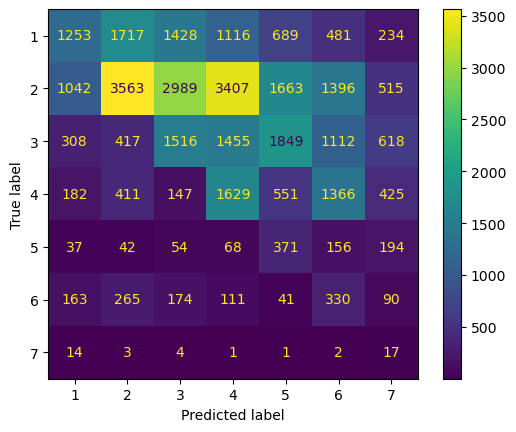

In [20]:
true_denticities = [len(label) for label in filtered_labels]
common_catoms = [7, 8, 9, 17, 35, 53]
pred_denticities = [len([a.GetAtomicNum() for a in ligand.GetAtoms() if a.GetAtomicNum() in common_catoms])
                    for ligand in filtered_mol_ls]

cm = confusion_matrix(true_denticities, pred_denticities, labels=np.arange(1, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, 8))
disp.plot()

In [22]:
num_correct = 0

for i in range(len(true_denticities)):
    true = true_denticities[i]
    pred = pred_denticities[i]

    if true == pred:
        num_correct += 1

frac_correct = num_correct / len(true_denticities)
print(f'The fraction of structures that have their denticity predicted correctly is {frac_correct:1.3f}.')

The fraction of structures that have their denticity predicted correctly is 0.207.


# Predicting Denticity with Partial Charge

In [26]:
#read data, make into 
df = pd.read_csv('ligand_properties_unique_hash.csv')
df = df.loc[df['Hemilabile'] == False]
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

labels = []
mol_ls = []
for i, x in tqdm(df.iterrows(), total=len(df)):
    try:
        mol = Chem.MolFromMol2Block(x['Ligand_mol2_Strings_without_X'], removeHs=False)
        label_ls = [int(j) for j in x['Connecting_Atom_Indices_without_XH'].strip('[]').replace(',', '').split()]
        mol_ls.append(mol)
        labels.append(label_ls)
    except:
        pass

allowed_atoms = {1, 6, 7, 8, 9, 15, 16, 17, 35, 53} #H, C, N, O, F, P, S, Cl, Br, I
filtered_mol_ls = []
filtered_labels = []
num_failed = 0

#Filter: ensure atoms are those specified above, no radicals (RDKit kekulized correctly)
#Ensure no trivial (1-heavy-atom) ligands, no heavily charged ligands, and ligand size less than 50

for i in tqdm(range(len(mol_ls))):
    #Some of the mol objects fail to generate, skip over those here
    if mol_ls[i] is None:
        num_failed += 1
        continue
    atom_list = [a.GetAtomicNum() for a in mol_ls[i].GetAtoms()]
    if set(atom_list).issubset(allowed_atoms) and \
        Descriptors.NumRadicalElectrons(mol_ls[i]) == 0 and\
        len(atom_list) >= 2 and \
        Chem.GetFormalCharge(mol_ls[i]) <= 2 and Chem.GetFormalCharge(mol_ls[i]) >= -4 and \
        len(atom_list) <= 50:
        filtered_mol_ls.append(mol_ls[i])
        filtered_labels.append(labels[i])
len(filtered_mol_ls), num_failed

100%|██████████| 78672/78672 [00:14<00:00, 5357.78it/s]


(30068, 7970)

In [40]:
charge_list = []
label_list = []

for idx, mol in tqdm(enumerate(filtered_mol_ls), total=len(filtered_mol_ls)):
    molec_props = Chem.AllChem.MMFFGetMoleculeProperties(mol)
    if molec_props:
        charges = np.array([molec_props.GetMMFFPartialCharge(i) for i, _ in enumerate(mol.GetAtoms())])
        charge_list.append(charges)
        label_list.append(filtered_labels[idx])
    else:
        pass
        '''
        print("MMFF charges not available for the input molecule, defaulting to Gasteiger charges.")
        AllChem.ComputeGasteigerCharges(mol)
        charges=np.array([a.GetDoubleProp('_GasteigerCharge') for a in mol.GetAtoms()])
        '''

100%|██████████| 30068/30068 [00:03<00:00, 9183.61it/s]


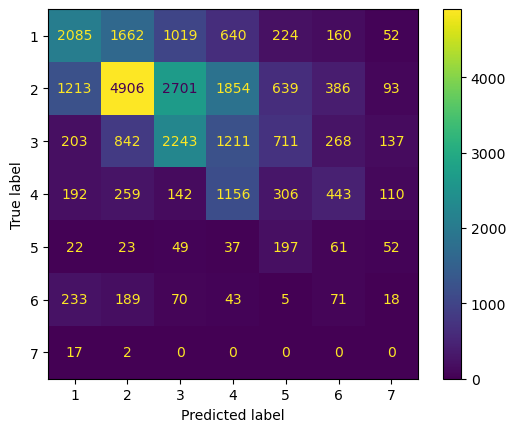

In [45]:
true_denticities = [len(label) for label in label_list]
pred_denticities = [len(np.where(charges < -0.5)[0]) for charges in charge_list]

cm = confusion_matrix(true_denticities, pred_denticities, labels=np.arange(1, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, 8))
disp.plot()

In [46]:
num_correct = 0

for i in range(len(true_denticities)):
    true = true_denticities[i]
    pred = pred_denticities[i]

    if true == pred:
        num_correct += 1

frac_correct = num_correct / len(true_denticities)
print(f'The fraction of structures that have their denticity predicted correctly is {frac_correct:1.3f}.')

The fraction of structures that have their denticity predicted correctly is 0.356.
